# MobileNet Quick Drew Example - With Pre-Train Model & Transfer Learning
- This notebook show you to load dataset, train mobilenet, test the model and convert to tflite for deployment on nuvoTon target board.
- Please follow the step by step and you could change the parameters for exploring the possibility.  

In [1]:
%matplotlib inline
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
import os
import sys
import ast
import re
import pathlib
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, DepthwiseConv2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, ReLU, GlobalAveragePooling2D 
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
start = dt.datetime.now()

In [2]:
#---------------------------------------------#
# Update parameters basing on your request
#---------------------------------------------#

DP_DIR = './dataset/simplified_small_bitmap_93nature'  # The shuffled dataset
TIME_COLOR = False                                     # If use time sequence to encode the value of grayscale
 
NUM_CATS = 93                                          # The classes number
 
WORK_DIR = './workspace/93nature_mobilenetv1_025_tf_2'   # The user defined name of work dir
MODEL_NAME = 'mobilenetv1_025_93'                       # The output model's name
PRETRAIN_DIR = './pretrain_model/mobilenetv1_025_340/' # The pretrain model loaction
 
 
INPUT_IMG_SIZE = 64                                    # The size of training input image
BATCHSIZE = 512                                        # For train data generator's batchsize => train data number every 1 epoch = STEPS_P_EPOCH * BATCHSIZE
 
EPOCHS = 15                                            # How many EPOCHS for transfer training.
 
USE_STEPS_EPOCH = True                                 # Please use this if the dataset is large. How many steps for 1 EPOCHS. 
STEPS_P_EPOCH = 1000                                   # Steps per epoch, 1 epochs will train BATCHSIZE * STEPS_P_EPOCH data
VALIDATION_BATCH_NUM = 40                              # How many validation data size for 1 Epochs = VALIDATION_BATCH_NUM * BATCHSIZE     
 
MODEL_TYPE = 'mobilenetv1'                             # 'mobilenetv1', 'mobilenetv2', 'mobilenetv3'
ALPHA_WIDTH = 0.25                                     # The width of the network. 1.0 is default, but maybe too large for MCU device.
#---------------------------------------------#

np.random.seed(seed=1987)
#tf.set_random_seed(seed=1987)
def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def create_dirs(proj_path, model_name): 
    if not os.path.exists(proj_path):
        os.makedirs(proj_path)
        os.makedirs(os.path.join(proj_path, model_name))
        os.makedirs(os.path.join(proj_path, 'tflite'))
        os.makedirs(os.path.join(proj_path, 'checkpoint'))
        os.makedirs(os.path.join(proj_path, 'opt'))
    else:
        print('Work folder exist!')    
    return proj_path

create_dirs(WORK_DIR, MODEL_NAME)    

'./workspace/93nature_mobilenetv1_025_tf_2'

## 1. Create Image Generator for training and the validation dataset

In [3]:

train_dataset = tf.keras.utils.image_dataset_from_directory(os.path.join(DP_DIR, 'train'),
                                                            label_mode='categorical', 
                                                            shuffle=True,
                                                            color_mode = 'grayscale',
                                                            batch_size=BATCHSIZE,
                                                            image_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE))
validation_dataset = tf.keras.utils.image_dataset_from_directory(os.path.join(DP_DIR, 'validation'),
                                                                 label_mode='categorical',
                                                                 shuffle=True,
                                                                 color_mode = 'grayscale',
                                                                 batch_size=BATCHSIZE,
                                                                 image_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE))

class_names = train_dataset.class_names
print('Class names: {}'.format(class_names))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Found 8928000 files belonging to 93 classes.
Found 1116000 files belonging to 93 classes.
Class names: ['ant', 'apple', 'arm', 'asparagus', 'banana', 'bear', 'bee', 'bird', 'blueberry', 'broccoli', 'bush', 'butterfly', 'camel', 'carrot', 'cat', 'cloud', 'cow', 'crab', 'crocodile', 'diamond', 'dog', 'dolphin', 'duck', 'ear', 'elephant', 'eye', 'face', 'finger', 'fish', 'flamingo', 'flower', 'foot', 'frog', 'giraffe', 'grapes', 'grass', 'hand', 'hedgehog', 'hurricane', 'kangaroo', 'leaf', 'leg', 'lightning', 'lion', 'monkey', 'moon', 'mosquito', 'mountain', 'mouse', 'mouth', 'mushroom', 'nose', 'ocean', 'octopus', 'onion', 'owl', 'palm tree', 'panda', 'parrot', 'peanut', 'pear', 'peas', 'penguin', 'pig', 'pineapple', 'potato', 'rabbit', 'rain', 'rainbow', 'rhinoceros', 'river', 'scorpion', 'sea turtle', 'shark', 'sheep', 'snail', 'snake', 'snowflake', 'spider', 'squirrel', 'star', 'strawberry', 'string bean', 'sun', 'swan', 'tiger', 'toe', 'tooth', 'tornado', 'tree', 'watermelon', 'whale

In [4]:
#@tf.autograph.experimental.do_not_convert
#@tf.function
def normalization_data( dataset):
    
    #if not TIME_COLOR:
    #    def no_time_color(x,y): 
    #        return tf.cond((x!=0), lambda: 255, lambda: 255) 
    #    out_dataset = dataset.map(lambda x, y: ((255 if x!=0. else 0), y), num_parallel_calls=tf.data.AUTOTUNE) # Change back to color 255 only

    # normalization for the data, expects pixel values in [-1, 1] from [0, 255]
    normalization_layer =  tf.keras.layers.Rescaling(1./127.5, offset=-1)
    #normalization_layer =  tf.keras.layers.Rescaling(1./255.)      
    out_dataset = dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return out_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset = normalization_data(train_dataset)
train_dataset = train_dataset.repeat()
validation_dataset = normalization_data(validation_dataset)
validation_dataset = validation_dataset.repeat()

train dataset example:


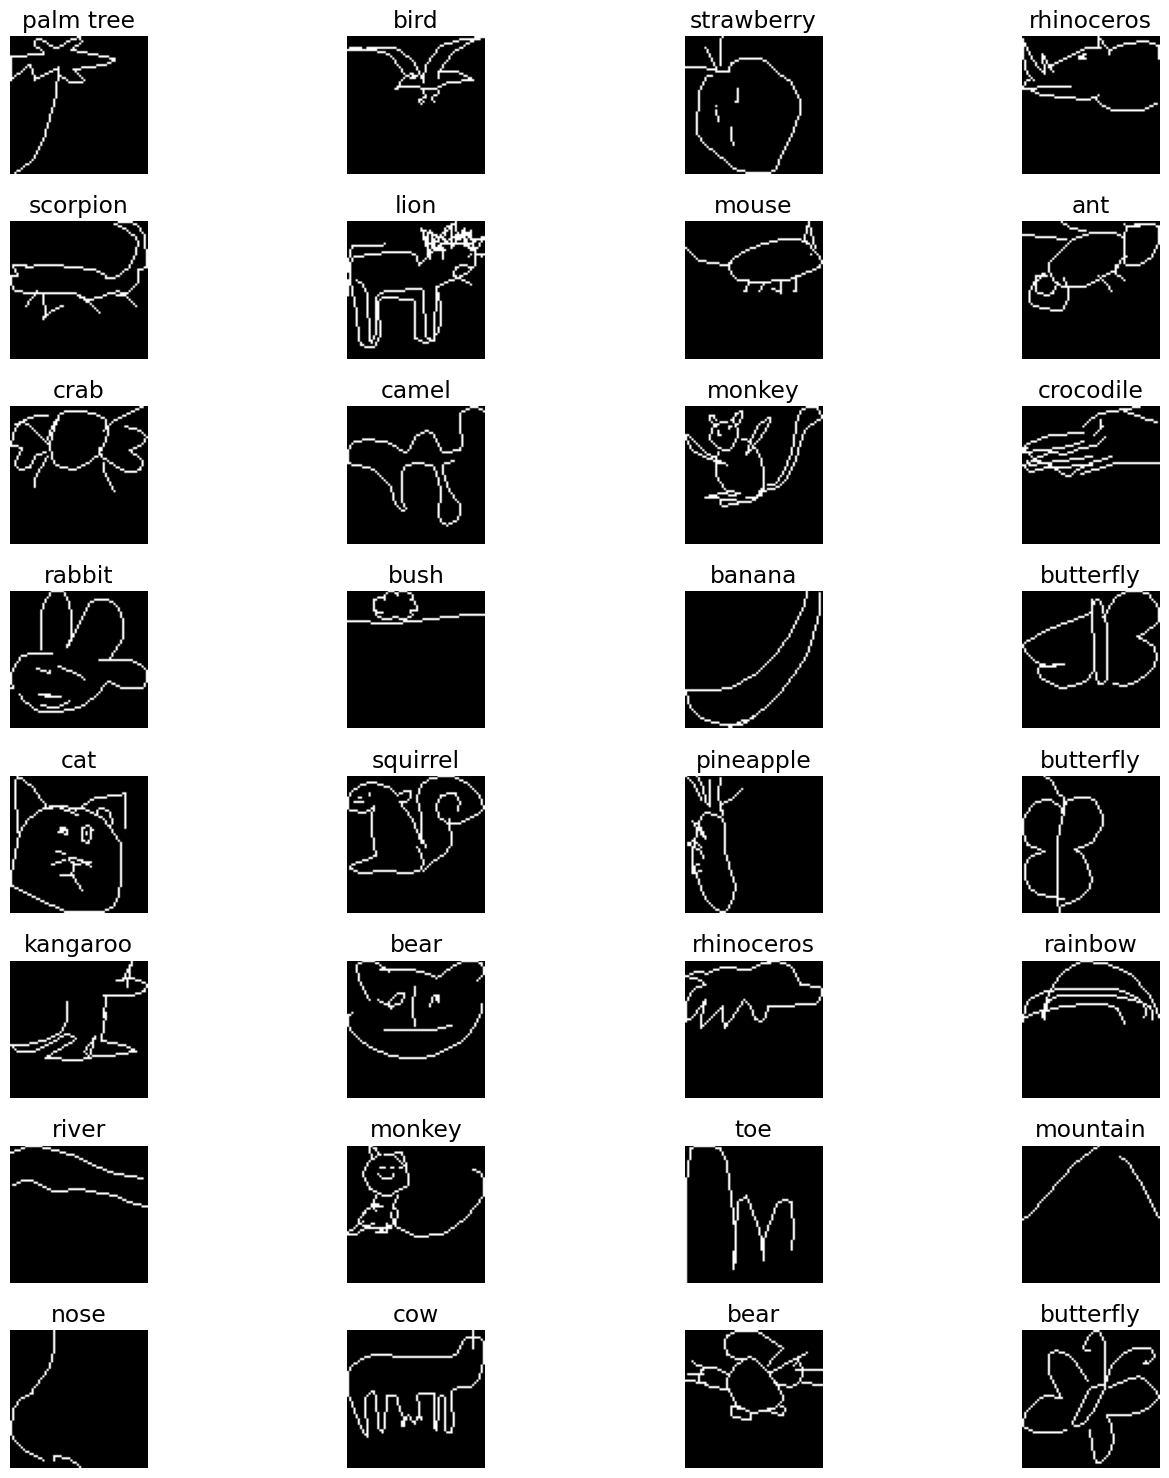

In [5]:
print("train dataset example:")
for images, labels in validation_dataset.take(1):
  plt.figure(figsize=(15, 15))
  x = 0
  for im, l in zip(images, labels):
    if x > 31:
          break   
    ax = plt.subplot(8, 4, x + 1)
    x = x +1
    #print(im)
    plt.imshow(im.numpy().astype("int8"), cmap=plt.cm.gray)
    plt.title(class_names[tf.math.argmax(l)])
    plt.axis("off")
  plt.tight_layout()
  plt.show();   

## 2. Start to train

- #### Load pre-train model, replace the classification head and use transfer learning.

In [6]:
def load_pretrain_model(md_path):
    # load the keras model and the custom op.
    base_model = keras.models.load_model(md_path, custom_objects={'top_3_accuracy':top_3_accuracy}, compile=False)
    base_model.trainable = False

    print("The total layers number: {}".format(len(base_model.layers)))

    # remove the last classification head
    x = base_model.layers[-4].output
   
    #yy = base_model.get_layer("mobilenet_0.25_64")
    #print(len(yy.layers))
    #print(yy.layers[85])

    # add the new classification head
    x = tf.keras.layers.Conv2D(NUM_CATS, (1, 1), padding="same")(x)
    x = tf.reshape(x,[-1, NUM_CATS])
    predictions = tf.keras.layers.Softmax()(x)
    #predictions = Dense(NUM_CATS, activation='softmax',  name='add_dense_1')(x)
    model = tf.keras.Model(base_model.input, predictions)

    return model

def find_best_ckpt(dir_path, model):
      pattern = re.compile(r"\d.\d+")
      max_number = None
      # Iterate over the files in the directory
      for file in dir_path.iterdir():
          filename = file.name
          match = pattern.search(filename)
          if match:
              number_str = match.group()
              number = float(number_str)
              if max_number is None or number > max_number:
                  max_number = number
      if max_number is None:
          print("There is no best ckpt in this work project.")  
      else:
          print("Find the best ckpt:{}".format(pathlib.Path(dir_path)/(number_str+f'_best_val.ckpt')))
          model.load_weights(str(pathlib.Path(dir_path)/(number_str+f'_best_val.ckpt')))   

          #load = tf.keras.models.load_model(dir_path, compile ="False")
          #model.set_weights(load.get_weights())   
      
      return model

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [7]:
if MODEL_TYPE.lower() == 'mobilenetv1':

    model = load_pretrain_model(PRETRAIN_DIR)
     
# If there is a checkpt, load the previous weights.
if (pathlib.Path(WORK_DIR)/'checkpoint').exists():    
    print("Previous checkpoint folder found; loading saved weights")
    model = find_best_ckpt((pathlib.Path(WORK_DIR)/'checkpoint'), model)
else:
    print("No checkpoint found, create the workfolder.")    

print("The trainable layers number: {}".format(len(model.trainable_variables)))
print(model.summary())


The total layers number: 7
Previous checkpoint folder found; loading saved weights
There is no best ckpt in this work project.
The trainable layers number: 2
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 mobilenet_0.25_64 (Function  (None, 2, 2, 256)        218400    
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1, 1, 256)        0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1, 1, 256)         0         
                                                                 
 conv2d (Conv2D)             (None,

- #### Training section
- The Epochs of transfer learning is samll because it trains the last layer only.
- This part is transfer learning training, and it takes 30~60mins (Nvdia RTX-3090 training from scratch) to get a decent result.
- The actual training time is basing on your hardware, usage size of training dataset and model scale.


In [8]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])


callbacks_chpt = tf.keras.callbacks.ModelCheckpoint(
                filepath=(os.path.join(WORK_DIR, 'checkpoint', '{val_categorical_accuracy:.3f}_best_val.ckpt')),
                save_weights_only=True, 
                monitor='val_categorical_accuracy',
                mode = 'max',
                save_best_only=True, 
                save_freq='epoch')

callbacks = [
    EarlyStopping(monitor='val_categorical_accuracy', patience=15, min_delta=0.001, mode='max'),
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, min_delta=0.005, mode='max', cooldown=3),
    callbacks_chpt
]

hists = []
if USE_STEPS_EPOCH: 
    validation_dataset_for_train = validation_dataset.take(VALIDATION_BATCH_NUM).prefetch(buffer_size=tf.data.AUTOTUNE)
    hist = model.fit(
        train_dataset, steps_per_epoch=STEPS_P_EPOCH, epochs=EPOCHS, verbose=1,
        validation_data=validation_dataset_for_train,
        callbacks = callbacks
    )
else:    
    hist = model.fit(
        train_dataset, epochs=EPOCHS, verbose=1,
        validation_data=validation_dataset,
        callbacks = callbacks
    )
hists.append(hist)

Epoch 1/15
1000/1000 [==============================] - 343s 337ms/step - loss: 0.9405 - categorical_crossentropy: 0.9405 - categorical_accuracy: 0.7499 - top_3_accuracy: 0.8942 - val_loss: 0.8113 - val_categorical_crossentropy: 0.8113 - val_categorical_accuracy: 0.7766 - val_top_3_accuracy: 0.9105 - lr: 0.0100
Epoch 2/15
1000/1000 [==============================] - 306s 307ms/step - loss: 0.8827 - categorical_crossentropy: 0.8827 - categorical_accuracy: 0.7592 - top_3_accuracy: 0.9013 - val_loss: 0.8041 - val_categorical_crossentropy: 0.8041 - val_categorical_accuracy: 0.7751 - val_top_3_accuracy: 0.9125 - lr: 0.0100
Epoch 3/15
1000/1000 [==============================] - 553s 553ms/step - loss: 0.8828 - categorical_crossentropy: 0.8828 - categorical_accuracy: 0.7595 - top_3_accuracy: 0.9017 - val_loss: 0.8109 - val_categorical_crossentropy: 0.8109 - val_categorical_accuracy: 0.7758 - val_top_3_accuracy: 0.9110 - lr: 0.0100
Epoch 4/15
1000/1000 [==============================] - 553s 

- #### Fine tune the transfer learning model by setting some layers as trainable
- The Epochs of fine tune is samll because it trains part of model layers.
- The actual training time is basing on your hardware, usage size of training dataset and model scale.

In [30]:
def unwrap_model_set_trainable(unwrap_model, fine_tune_layers_at, base_model_trainable_EN=True):

    print("The original layers number: {}".format(len(unwrap_model.layers)))
    print("The original trainable layers number: {}".format(len(unwrap_model.trainable_variables)))

    mn_name = unwrap_model.layers[1].name # need the name of base model to get the intermediate layers
    print("The name of unwraping pretrain base model: {}".format(mn_name))
    base_model = unwrap_model.get_layer(mn_name)
    print("The total layers number of base model: {}".format(len(base_model.layers)))
    
    # Freeze all the layers before the `fine_tune_at` layer
    base_model.trainable = base_model_trainable_EN
    if fine_tune_layers_at >= len(base_model.layers):
        print("Warning: The 'fine_tune_layers_at' is larger than siez of base_model layer. There are no new trainable layers for fine-tune!!")
    else:    
        for layer in base_model.layers[:fine_tune_layers_at]:
            layer.trainable = False
    print("The trainable layers number of base model: {}".format(len(base_model.trainable_variables)))

    inp = base_model.input
    out = unwrap_model.get_layer(unwrap_model.layers[2].name)(base_model.output)
    for i in range(3, len(unwrap_model.layers)):    
        if unwrap_model.layers[i].name.count('tf.reshape'): # the model.get_layer('tf.reshape') need other way to insert.
            out = tf.reshape(out,[-1, NUM_CATS])
        else:
            out = unwrap_model.get_layer(unwrap_model.layers[i].name)(out)
    
    return tf.keras.Model(inp, out)   

# If there is a checkpt, load the previous weights.
#if (pathlib.Path(WORK_DIR)/'checkpoint').exists():    
#    print("Previous checkpoint folder found; loading saved weights")
#    model = find_best_ckpt((pathlib.Path(WORK_DIR)/'checkpoint'), model)
#else:
#    print("No checkpoint found, create the workfolder.") 

# Setup the finetune model
unwrapped_finetune_model = unwrap_model_set_trainable(model, 60)
unwrapped_finetune_model.summary()
print("The total layers number: {}".format(len(unwrapped_finetune_model.layers)))
print("The trainable layers number: {}".format(len(unwrapped_finetune_model.trainable_variables)))

The original layers number: 7
The original trainable layers number: 47
The name of unwraping pretrain base model: mobilenet_0.25_64
The total layers number of base model: 86
The trainable layers number of base model: 24
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 8)         72        
                                                                 
 conv1_bn (BatchNormalizatio  (None, 32, 32, 8)        32        
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 32, 32, 8)         0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 

In [31]:
EPOCHS_FINETUNE = 15

# Compile the model
if MODEL_TYPE.lower() == 'mobilenetv1':
    unwrapped_finetune_model.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
callbacks_finetune = [
    EarlyStopping(monitor='val_categorical_accuracy', patience=15, min_delta=0.001, mode='max'),
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, min_delta=0.005, mode='max', cooldown=3),
]    

# Training section
if USE_STEPS_EPOCH:
    validation_dataset_for_train = validation_dataset.take(VALIDATION_BATCH_NUM).prefetch(buffer_size=tf.data.AUTOTUNE)
    hist_finetune = unwrapped_finetune_model.fit(
        train_dataset, steps_per_epoch=STEPS_P_EPOCH, epochs=EPOCHS_FINETUNE, verbose=1,
        validation_data=validation_dataset_for_train,
        callbacks = callbacks_finetune
    )
else:
    hist_finetune = unwrapped_finetune_model.fit(
        train_dataset, epochs=EPOCHS_FINETUNE, verbose=1,
        validation_data=validation_dataset,
        callbacks = callbacks_finetune
    )
hists.append(hist_finetune)

Epoch 1/15


1000/1000 [==============================] - 59s 57ms/step - loss: 0.8018 - categorical_crossentropy: 0.8018 - categorical_accuracy: 0.7799 - top_3_accuracy: 0.9125 - val_loss: 0.7955 - val_categorical_crossentropy: 0.7955 - val_categorical_accuracy: 0.7825 - val_top_3_accuracy: 0.9122 - lr: 0.0050
Epoch 2/15
1000/1000 [==============================] - 55s 55ms/step - loss: 0.7772 - categorical_crossentropy: 0.7772 - categorical_accuracy: 0.7861 - top_3_accuracy: 0.9159 - val_loss: 0.7965 - val_categorical_crossentropy: 0.7965 - val_categorical_accuracy: 0.7820 - val_top_3_accuracy: 0.9141 - lr: 0.0050
Epoch 3/15
1000/1000 [==============================] - 514s 514ms/step - loss: 0.8044 - categorical_crossentropy: 0.8044 - categorical_accuracy: 0.7804 - top_3_accuracy: 0.9122 - val_loss: 0.7760 - val_categorical_crossentropy: 0.7760 - val_categorical_accuracy: 0.7867 - val_top_3_accuracy: 0.9144 - lr: 0.0050
Epoch 4/15
1000/1000 [==============================] - 561s 562ms/step - lo

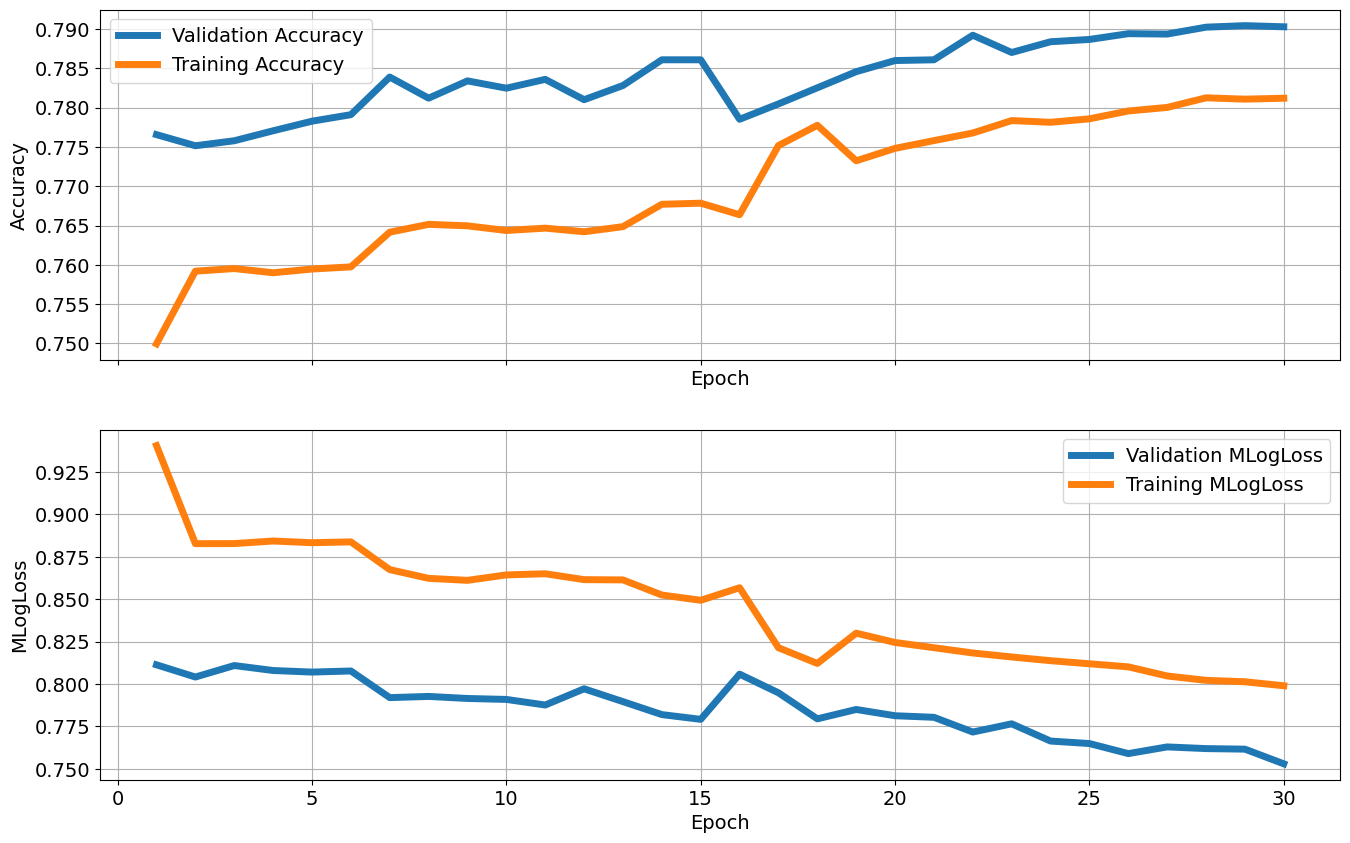

In [15]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig(os.path.join(WORK_DIR,'hist.png'), dpi=300)
plt.show();

## 3. Validation and test the model
- We knew the validation set's accuracy, and make sure the testdataset is almost the same.

In [32]:
test_dataset = tf.keras.utils.image_dataset_from_directory(os.path.join(DP_DIR, 'test'),
                                                            label_mode='categorical', 
                                                            shuffle=True,
                                                            color_mode = 'grayscale',
                                                            batch_size=BATCHSIZE,
                                                            image_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE))
test_dataset = normalization_data(test_dataset)

Found 1093466 files belonging to 93 classes.


In [33]:
loss, crossentropy, top1, top3= unwrapped_finetune_model.evaluate(test_dataset)
print('Top1 Accuracy: {:.3f}'.format(top1))
print('Top3 Accuracy: {:.3f}'.format(top3))

2136/2136 [==============================] - 1079s 503ms/step - loss: 0.7419 - categorical_crossentropy: 0.7419 - categorical_accuracy: 0.7949 - top_3_accuracy: 0.9200
Top1 Accuracy: 0.795
Top3 Accuracy: 0.920


## 4. Save the model

In [34]:
unwrapped_finetune_model.save(os.path.join(WORK_DIR, MODEL_NAME))
#tf.keras.models.save_model(model, os.path.join(WORK_DIR, MODEL_NAME))

INFO:tensorflow:Assets written to: ./workspace/93nature_mobilenetv1_025_tf_2\mobilenetv1_025_93\assets


INFO:tensorflow:Assets written to: ./workspace/93nature_mobilenetv1_025_tf_2\mobilenetv1_025_93\assets


## 5. Convert to tflite
- Include quantization and offer normal, dynamic quantization, float16 quantization and int8 quantization tflite.

In [35]:
def convert2tflite(custom_model_path, output_tflite_location, rep_batch_num):
      
      def representative_dataset():
        idx = 0
        for images, _ in validation_dataset.take(rep_batch_num):
            idx = 0
            for i in range(BATCHSIZE): 
                idx = idx + 1
                image = tf.expand_dims(images[i], axis=0)
                #image = tf.dtypes.cast(image, tf.float32) 
                yield [image] # total loop is rep_batch_num * BATCHSIZE    
      
      # load the keras model and the custom op.
      custom_model = keras.models.load_model(custom_model_path, custom_objects={'top_3_accuracy':top_3_accuracy})

      # normal tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (MODEL_NAME + r'.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location)) 
      
      # dynamic tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      converter.optimizations = [tf.lite.Optimize.DEFAULT]
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (MODEL_NAME + r'_dyquant.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location))
      
      # int8 Full tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      converter.optimizations = [tf.lite.Optimize.DEFAULT]
      converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS]
      converter.representative_dataset = representative_dataset
      converter.inference_input_type = tf.int8  # or tf.uint8
      converter.inference_output_type = tf.int8  # or tf.uint8
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (MODEL_NAME + r'_int8quant.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location)) 
      
      # f16 tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      converter.optimizations = [tf.lite.Optimize.DEFAULT]
      converter.target_spec.supported_types = [tf.float16]
      #converter.representative_dataset = representative_dataset
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (MODEL_NAME + r'_f16quant.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location))

In [36]:
convert2tflite(os.path.join(WORK_DIR, MODEL_NAME), os.path.join(WORK_DIR, 'tflite'), 5)

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp0qwlbqrz\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp0qwlbqrz\assets
c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


The tflite output location: ./workspace/93nature_mobilenetv1_025_tf_2\tflite\mobilenetv1_025_93_int8quant.tflite


- #### Test the tflite to make sure the accuracy. 

In [37]:
from tqdm import tqdm

def preds2catIdx(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top3_acc( tgt, pred ):
    sc = np.mean( (pred[:,0]==tgt) | (pred[:,1]==tgt) | (pred[:,2]==tgt) )
    return sc

def top1_acc( tgt, pred ):
    sc = np.mean( (pred[:,0]==tgt))
    return sc

def tflite_inference(input_dataset, tflite_path, batch_N):
      """Call forwards pass of TFLite file and returns the result.
  
      Args:
          input_data: Input data to use on forward pass.
          tflite_path: Path to TFLite file to run.
  
      Returns:
          Output from inference.
      """

      interpreter = tf.lite.Interpreter(model_path=tflite_path)
      
  
      input_details = interpreter.get_input_details()
      output_details = interpreter.get_output_details()
  
      input_dtype = input_details[0]["dtype"]
      output_dtype = output_details[0]["dtype"]

      input_shape = input_details[0]['shape']
      output_shape = output_details[0]['shape']
      #interpreter.resize_tensor_input(input_details[0]['index'], [batch_N, input_shape[1], input_shape[2], input_shape[3]])
      #interpreter.resize_tensor_input(output_details[0]['index'], [batch_N, output_shape[1]])

      interpreter.allocate_tensors()
  
      # Check if the input/output type is quantized,
      # set scale and zero-point accordingly
      if input_dtype == np.int8:
          input_scale, input_zero_point = input_details[0]["quantization"]
          def fun_cal(x, y):
              #return tf.math.round((x) / input_scale + input_zero_point), y
              return tf.math.round(x - 128), y # If the dataset didn't normalize, use this
           
          input_dataset = input_dataset.map(fun_cal, num_parallel_calls=tf.data.AUTOTUNE)
      else:
          input_scale, input_zero_point = 1, 0

          input_scale, input_zero_point = input_details[0]["quantization"]
          def fun_cal(x, y):
              return x / input_scale + input_zero_point, y
           
          input_dataset = input_dataset.map(fun_cal, num_parallel_calls=tf.data.AUTOTUNE)
  
      if input_dtype == np.int8:
          output_scale, output_zero_point = output_details[0]["quantization"]
      else:
          output_scale, output_zero_point = 1, 0
      

      progress = tqdm(total=BATCHSIZE*batch_N)
      acy_top1  = 0
      acy_top3 = 0

      for images, labels in input_dataset.take(batch_N):
        
        for im, l in zip(images, labels):

          input_data = tf.expand_dims(im, axis=0)
          
          interpreter.set_tensor(input_details[0]['index'], tf.cast(input_data, input_dtype))
          interpreter.invoke()

          output_data = interpreter.get_tensor(output_details[0]['index'])
          output_data = output_scale * (output_data.astype(np.float32) - output_zero_point)
          #print(output_data, l.numpy())

          acy_top1 += top1_acc(l.numpy().flatten(), preds2catIdx(output_data).values)
          acy_top3 += top3_acc(l.numpy().flatten(), preds2catIdx(output_data).values)

          progress.update(1)

      return   acy_top1/(BATCHSIZE*batch_N), acy_top3/(BATCHSIZE*batch_N)


In [38]:
#top1, top3 = tflite_inference(x_valid[0:64], valid_df[['y']][0:64], os.path.join(WORK_DIR, 'tflite', (MODEL_NAME + r'_dyquant.tflite')), 32) 
tflite_test_dataset = tf.keras.utils.image_dataset_from_directory(os.path.join(DP_DIR, 'test'),
                                                            label_mode='int', 
                                                            shuffle=True,
                                                            color_mode = 'grayscale',
                                                            batch_size=BATCHSIZE,
                                                            image_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE))

Found 1093466 files belonging to 93 classes.


In [39]:
top1, top3= tflite_inference(tflite_test_dataset, os.path.join(WORK_DIR, 'tflite', (MODEL_NAME + r'_int8quant.tflite')), 40) 

  0%|          | 0/20480 [00:00<?, ?it/s]

100%|██████████| 20480/20480 [04:18<00:00, 79.09it/s]


In [40]:
print('Top1 Accuracy: {:.3f}'.format(top1))
print('Top3 Accuracy: {:.3f}'.format(top3))  

Top1 Accuracy: 0.795
Top3 Accuracy: 0.920


## 6. Quantization aware training (Optional)
- If the tflite model accuracy drops a lot comparing with original keras model.
- This may help the tflite model to keep the accuracy.

In [25]:
import tensorflow_model_optimization as tfmot

#quantize_model = tfmot.quantization.keras.quantize_model

# load the keras model and the custom op.
model = keras.models.load_model(os.path.join(WORK_DIR, MODEL_NAME), custom_objects={'top_3_accuracy':top_3_accuracy})



#added layers here
supported_layers = [tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D, 
                    tf.keras.layers.ReLU, tf.keras.layers.BatchNormalization,
                    tf.keras.layers.Softmax, tf.keras.layers.GlobalAveragePooling2D,
                    tf.keras.layers.Dropout]
#supported_layers = [tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D]

def apply_quantization_to_dense(layer):
  for supported_layer in supported_layers:
    if isinstance(layer, supported_layer):
      return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization_to_dense,
)


# q_aware stands for for quantization aware.
q_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

q_aware_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])

q_aware_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 quantize_layer (QuantizeLay  (None, 64, 64, 1)        3         
 er)                                                             
                                                                 
 quant_conv1 (QuantizeWrappe  (None, 32, 32, 8)        89        
 rV2)                                                            
                                                                 
 quant_conv1_bn (QuantizeWra  (None, 32, 32, 8)        33        
 pperV2)                                                         
                                                                 
 quant_conv1_relu (QuantizeW  (None, 32, 32, 8)        3         
 rapperV2)                                                 

In [27]:
EPOCHS_Q_AWARE = 2

callbacks_q_aware = [
    EarlyStopping(monitor='val_categorical_accuracy', patience=15, min_delta=0.003, mode='max'),
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, min_delta=0.005, mode='max', cooldown=3),
] 


# Training section
if USE_STEPS_EPOCH:
    validation_dataset_for_train = validation_dataset.take(VALIDATION_BATCH_NUM).prefetch(buffer_size=tf.data.AUTOTUNE)
    hist_q_aware = q_aware_model.fit(
        train_dataset, steps_per_epoch=STEPS_P_EPOCH, epochs=EPOCHS_Q_AWARE, verbose=1,
        validation_data=validation_dataset_for_train,
        callbacks = callbacks_finetune
    )
else:
    hist_q_aware = q_aware_model.fit(
    train_dataset, epochs=EPOCHS_Q_AWARE, verbose=1,
    validation_data=validation_dataset,
    callbacks = callbacks_q_aware
)

Epoch 1/2


1000/1000 [==============================] - 579s 570ms/step - loss: 0.8699 - categorical_crossentropy: 0.8699 - categorical_accuracy: 0.7606 - top_3_accuracy: 0.9060 - val_loss: 0.9242 - val_categorical_crossentropy: 0.9242 - val_categorical_accuracy: 0.7463 - val_top_3_accuracy: 0.8936 - lr: 1.0000e-04
Epoch 2/2
1000/1000 [==============================] - 520s 520ms/step - loss: 0.8424 - categorical_crossentropy: 0.8424 - categorical_accuracy: 0.7710 - top_3_accuracy: 0.9082 - val_loss: 0.8194 - val_categorical_crossentropy: 0.8194 - val_categorical_accuracy: 0.7724 - val_top_3_accuracy: 0.9116 - lr: 1.0000e-04


In [28]:
loss, crossentropy, top1, top3= q_aware_model.evaluate(test_dataset)
print('Top1 Accuracy: {:.3f}'.format(top1))
print('Top3 Accuracy: {:.3f}'.format(top3))

2136/2136 [==============================] - 858s 400ms/step - loss: 0.8349 - categorical_crossentropy: 0.8349 - categorical_accuracy: 0.7712 - top_3_accuracy: 0.9097
Top1 Accuracy: 0.771
Top3 Accuracy: 0.910


In [16]:
# int8 Full tflite
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_model = converter.convert()
output_location = os.path.join(os.path.join(WORK_DIR, 'opt'), (MODEL_NAME + r'_QATint8quant.tflite'))
with open(output_location, 'wb') as f:
      f.write(tflite_model)
print("The tflite output location: {}".format(output_location)) 

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp36np95yt\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp36np95yt\assets
c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


The tflite output location: ./workspace/5_mobilenetv1_025_tf\opt\mobilenetv1_025_5_QATint8quant_batch.tflite


In [20]:
top1, top3= tflite_inference(tflite_test_dataset, os.path.join(WORK_DIR, 'opt', (MODEL_NAME + r'_QATint8quant.tflite')), 60)

100%|██████████| 30720/30720 [06:31<00:00, 78.50it/s]


In [21]:
print('Top1 Accuracy: {:.3f}'.format(top1))
print('Top3 Accuracy: {:.3f}'.format(top3))  

Top1 Accuracy: 0.941
Top3 Accuracy: 0.988
